In [1]:
import gpytorch

from bo_functions import best_error_advanced
from bo_functions import calc_ei_advanced
from bo_functions import LHS_Design
from bo_functions import create_y_data
from bo_functions import test_train_split
from bo_functions import ExactGPModel
from bo_functions import train_GP_model
from bo_functions import calc_GP_outputs
from bo_functions import calc_y_expected

from bo_plotters import plotter_adv
from bo_plotters import y_plotter_adv
from bo_plotters import stdev_plotter_adv
from bo_plotters import ei_plotter_adv

In [2]:
#Set noise parameters and load csv file to generate training data
noise_std = 0.1**2
all_p = LHS_Design("LHS_Toy_3_Input.csv")
all_y = create_y_data(all_p, noise_std)

#Separate training and testing data, uses default of an 80%/20% split
train_test_data = test_train_split(all_p,all_y)

train_p = train_test_data[0] #1x19
train_y = train_test_data[1] #1x19
test_p = train_test_data[2] #1x19
test_y = train_test_data[3] #1x19

In [3]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_p, train_y, likelihood)

In [4]:
#Set number of training iterations and run GP
iterations = 500
train_GP_model(model,likelihood, train_p, train_y, iterations)
# #Find optimal model hyperparameters
# training_iter = 300

# #Puts the model in training mode
# model.train()

# #Puts the likelihood in training mode
# likelihood.train()

# # Use the adam optimizer
#     #algorithm for first-order gradient-based optimization of stochastic objective functions
#     # The method is also appropriate for non-stationary objectives and problems with very noisy and/or sparse gradients. 
#     #The hyper-parameters have intuitive interpretations and typically require little tuning.
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  #Needs GaussianLikelihood parameters, and a learning rate
#     #lr default is 0.001

# # Calculate"Loss" for GPs

# #The marginal log likelihood (the evidence: quantifies joint probability of the data under the prior)
# #returns an exact MLL for an exact Gaussian process with Gaussian likelihood
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model) #Takes a Gaussian likelihood and a model, a bound Method
# #iterates a give number of times
# for i in range(training_iter): #0-299
#     # Zero gradients from previous iteration - Prevents past gradients from influencing the next iteration
#     optimizer.zero_grad() 
#     # Output from model
#     output = model(train_p) # A multivariate norm of a 1 x 19^2 tensor
#     # Calc loss and backprop gradients
#     #Minimizing -logMLL lets us fit hyperparameters
#     loss = -mll(output, train_y) #A number (tensor)
#     #computes dloss/dx for every parameter x which has requires_grad=True. 
#     #These are accumulated into x.grad for every parameter x
#     loss.backward()
# #     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
# #         i + 1, training_iter, loss.item(),
# #         model.covar_module.base_kernel.lengthscale.item(),
# #          model.likelihood.noise.item()
# #     ))
#     #optimizer.step updates the value of x using the gradient x.grad. For example, the SGD optimizer performs:
#     #x += -lr * x.grad
#     optimizer.step()

In [5]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [6]:
#Calculates GP outputs for mean, variance, standard devaition, and y output
GP_Outputs = calc_GP_outputs(model,likelihood,test_p)

model_mean = GP_Outputs[0] #1x6
model_variance= GP_Outputs[1] #1x6
model_stdev = GP_Outputs[2] #1x6
model_y = GP_Outputs[3] #1x6

#Calculates expected y
y_exp = calc_y_expected(test_p, noise_std) #1x6

In [7]:
#Calculates best_error and expected improvement
best_error = best_error_advanced(model_y, y_exp)[0] #Scaler
best_x = best_error_advanced(model_y, y_exp)[1] #1x3
ei = calc_ei_advanced(best_error,model_mean,model_variance, y_exp) #1x6
print(ei)

[0.29084075 0.28362863 0.29182854 0.30587214 0.2088194  0.15887495]


In [8]:
#Test calc_ei_adv (to compare with hand calcs)
import numpy as np
import torch
f_best = 1.0
mu = torch.tensor([3])
y_exp = np.array([4])
pred_var = torch.tensor([1])
#print(calc_ei_advanced(f_best,mu,pred_var,y_exp))

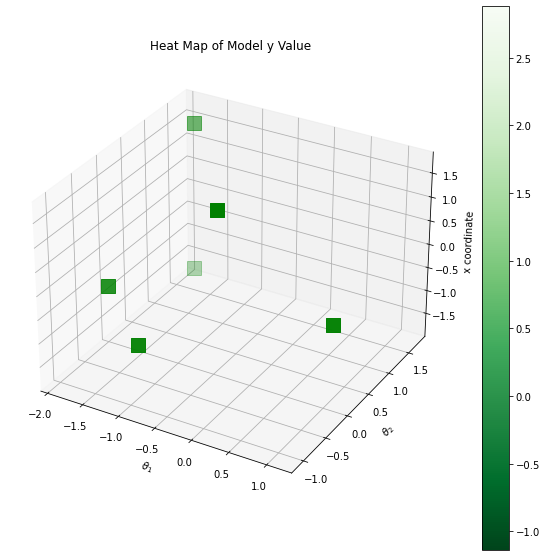

None


In [9]:
y_title = "Model y Value"
print(y_plotter_adv(test_p, model_y, y_title))

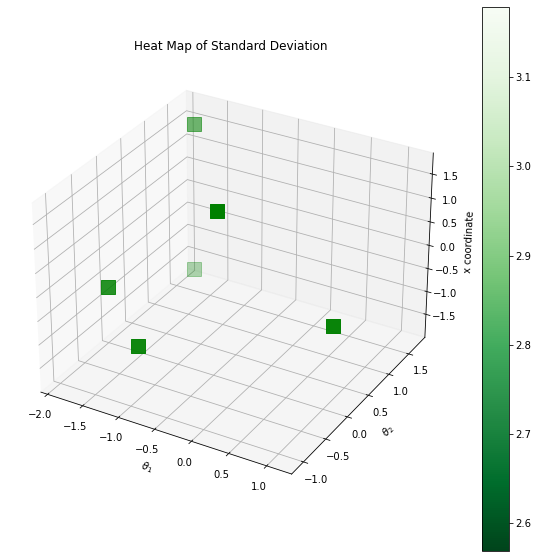

None


In [10]:
print(stdev_plotter_adv(test_p, model_stdev))

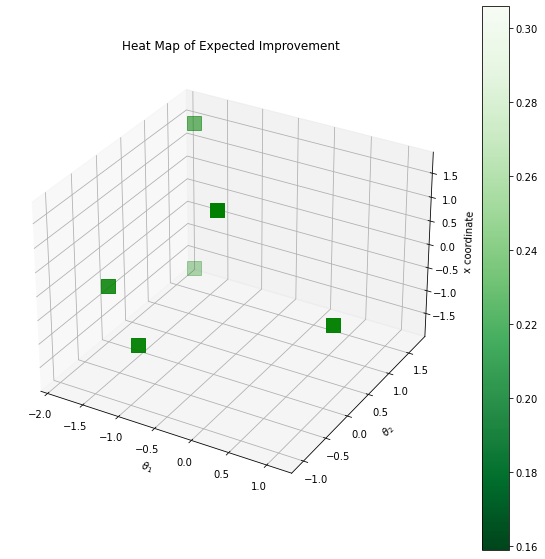

None


In [11]:
print(ei_plotter_adv(test_p, ei))